In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.initializers import HeNormal
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import random
import tensorflow as tf

# Set a seed value for reproducibility
seed_value = 42

# For NumPy
np.random.seed(seed_value)

# For Python random module
random.seed(seed_value)

# For TensorFlow
tf.random.set_seed(seed_value)


In [146]:

!mkdir -p ~/.kaggle
!cp kaggle-2.json ~/.kaggle/


cp: cannot stat 'kaggle-2.json': No such file or directory


In [147]:
! kaggle datasets download -d "minatverma/nse-stocks-data"


Dataset URL: https://www.kaggle.com/datasets/minatverma/nse-stocks-data
License(s): CC0-1.0
nse-stocks-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [148]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nse-stocks-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [149]:
data=pd.read_csv('/content/FINAL_FROM_DF.csv')

In [150]:
data.head()

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
0,20MICRONS,EQ,37.80,37.80,36.15,36.85,37.40,37.05,27130,994657.90,2017-06-28,202,INE144J01027
1,3IINFOTECH,EQ,4.10,4.85,4.00,4.55,4.65,4.05,20157058,92148517.65,2017-06-28,7353,INE748C01020
2,3MINDIA,EQ,13425.15,13469.55,12920.00,13266.70,13300.00,13460.55,2290,30304923.35,2017-06-28,748,INE470A01017
3,63MOONS,EQ,61.00,61.90,60.35,61.00,61.10,60.65,27701,1689421.00,2017-06-28,437,INE111B01023
4,8KMILES,EQ,546.10,548.00,535.00,537.45,535.20,547.45,79722,43208620.05,2017-06-28,1866,INE650K01021


In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846404 entries, 0 to 846403
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SYMBOL       846404 non-null  object 
 1   SERIES       843947 non-null  object 
 2   OPEN         846404 non-null  float64
 3   HIGH         846404 non-null  float64
 4   LOW          846404 non-null  float64
 5   CLOSE        846404 non-null  float64
 6   LAST         846404 non-null  float64
 7   PREVCLOSE    846404 non-null  float64
 8   TOTTRDQTY    846404 non-null  int64  
 9   TOTTRDVAL    846404 non-null  float64
 10  TIMESTAMP    846404 non-null  object 
 11  TOTALTRADES  846404 non-null  int64  
 12  ISIN         846404 non-null  object 
dtypes: float64(7), int64(2), object(4)
memory usage: 83.9+ MB


In [152]:
data['TIMESTAMP']=pd.to_datetime(data['TIMESTAMP'])

In [153]:
data['SYMBOL'].value_counts()

,count
SYMBOL,
SRTRANSFIN,4709
IDFCBANK,4379
IRFC,4362
NHAI,3360
RECLTD,2919
...,...
M17RD,1
CP7RG,1
IPRU2814,1


In [154]:
idfc=data[(data['SYMBOL']=='IDFCBANK')& (data['SERIES']=='EQ')]

In [155]:
# Sort the data by date
idfc= idfc.sort_values(by='TIMESTAMP', ascending=True)


In [156]:
idfc.isnull().sum()

,0
SYMBOL,0
SERIES,0
OPEN,0
HIGH,0
LOW,0
CLOSE,0
LAST,0
PREVCLOSE,0
TOTTRDQTY,0
TOTTRDVAL,0


In [157]:
idfc=idfc.drop(['SYMBOL','SERIES','ISIN'],axis=1)

In [158]:
# Set 'Date' as the index
idfc.set_index('TIMESTAMP', inplace=True)


In [159]:
idfc.corr()

,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TOTALTRADES
OPEN,1.000000,0.991984,0.991920,0.987385,0.986994,0.995470,0.286868,0.340175,0.563118
HIGH,0.991984,1.000000,0.988279,0.995503,0.995311,0.991451,0.312977,0.364320,0.597273
LOW,0.991920,0.988279,1.000000,0.993408,0.992910,0.991492,0.279426,0.332218,0.551565
CLOSE,0.987385,0.995503,0.993408,1.000000,0.999786,0.988958,0.300292,0.352038,0.576880
LAST,0.986994,0.995311,0.992910,0.999786,1.000000,0.988611,0.302467,0.354377,0.577993
PREVCLOSE,0.995470,0.991451,0.991492,0.988958,0.988611,1.000000,0.289757,0.343240,0.561899
TOTTRDQTY,0.286868,0.312977,0.279426,0.300292,0.302467,0.289757,1.000000,0.995175,0.686219
TOTTRDVAL,0.340175,0.364320,0.332218,0.352038,0.354377,0.343240,0.995175,1.000000,0.691903
TOTALTRADES,0.563118,0.597273,0.551565,0.576880,0.577993,0.561899,0.686219,0.691903,1.000000


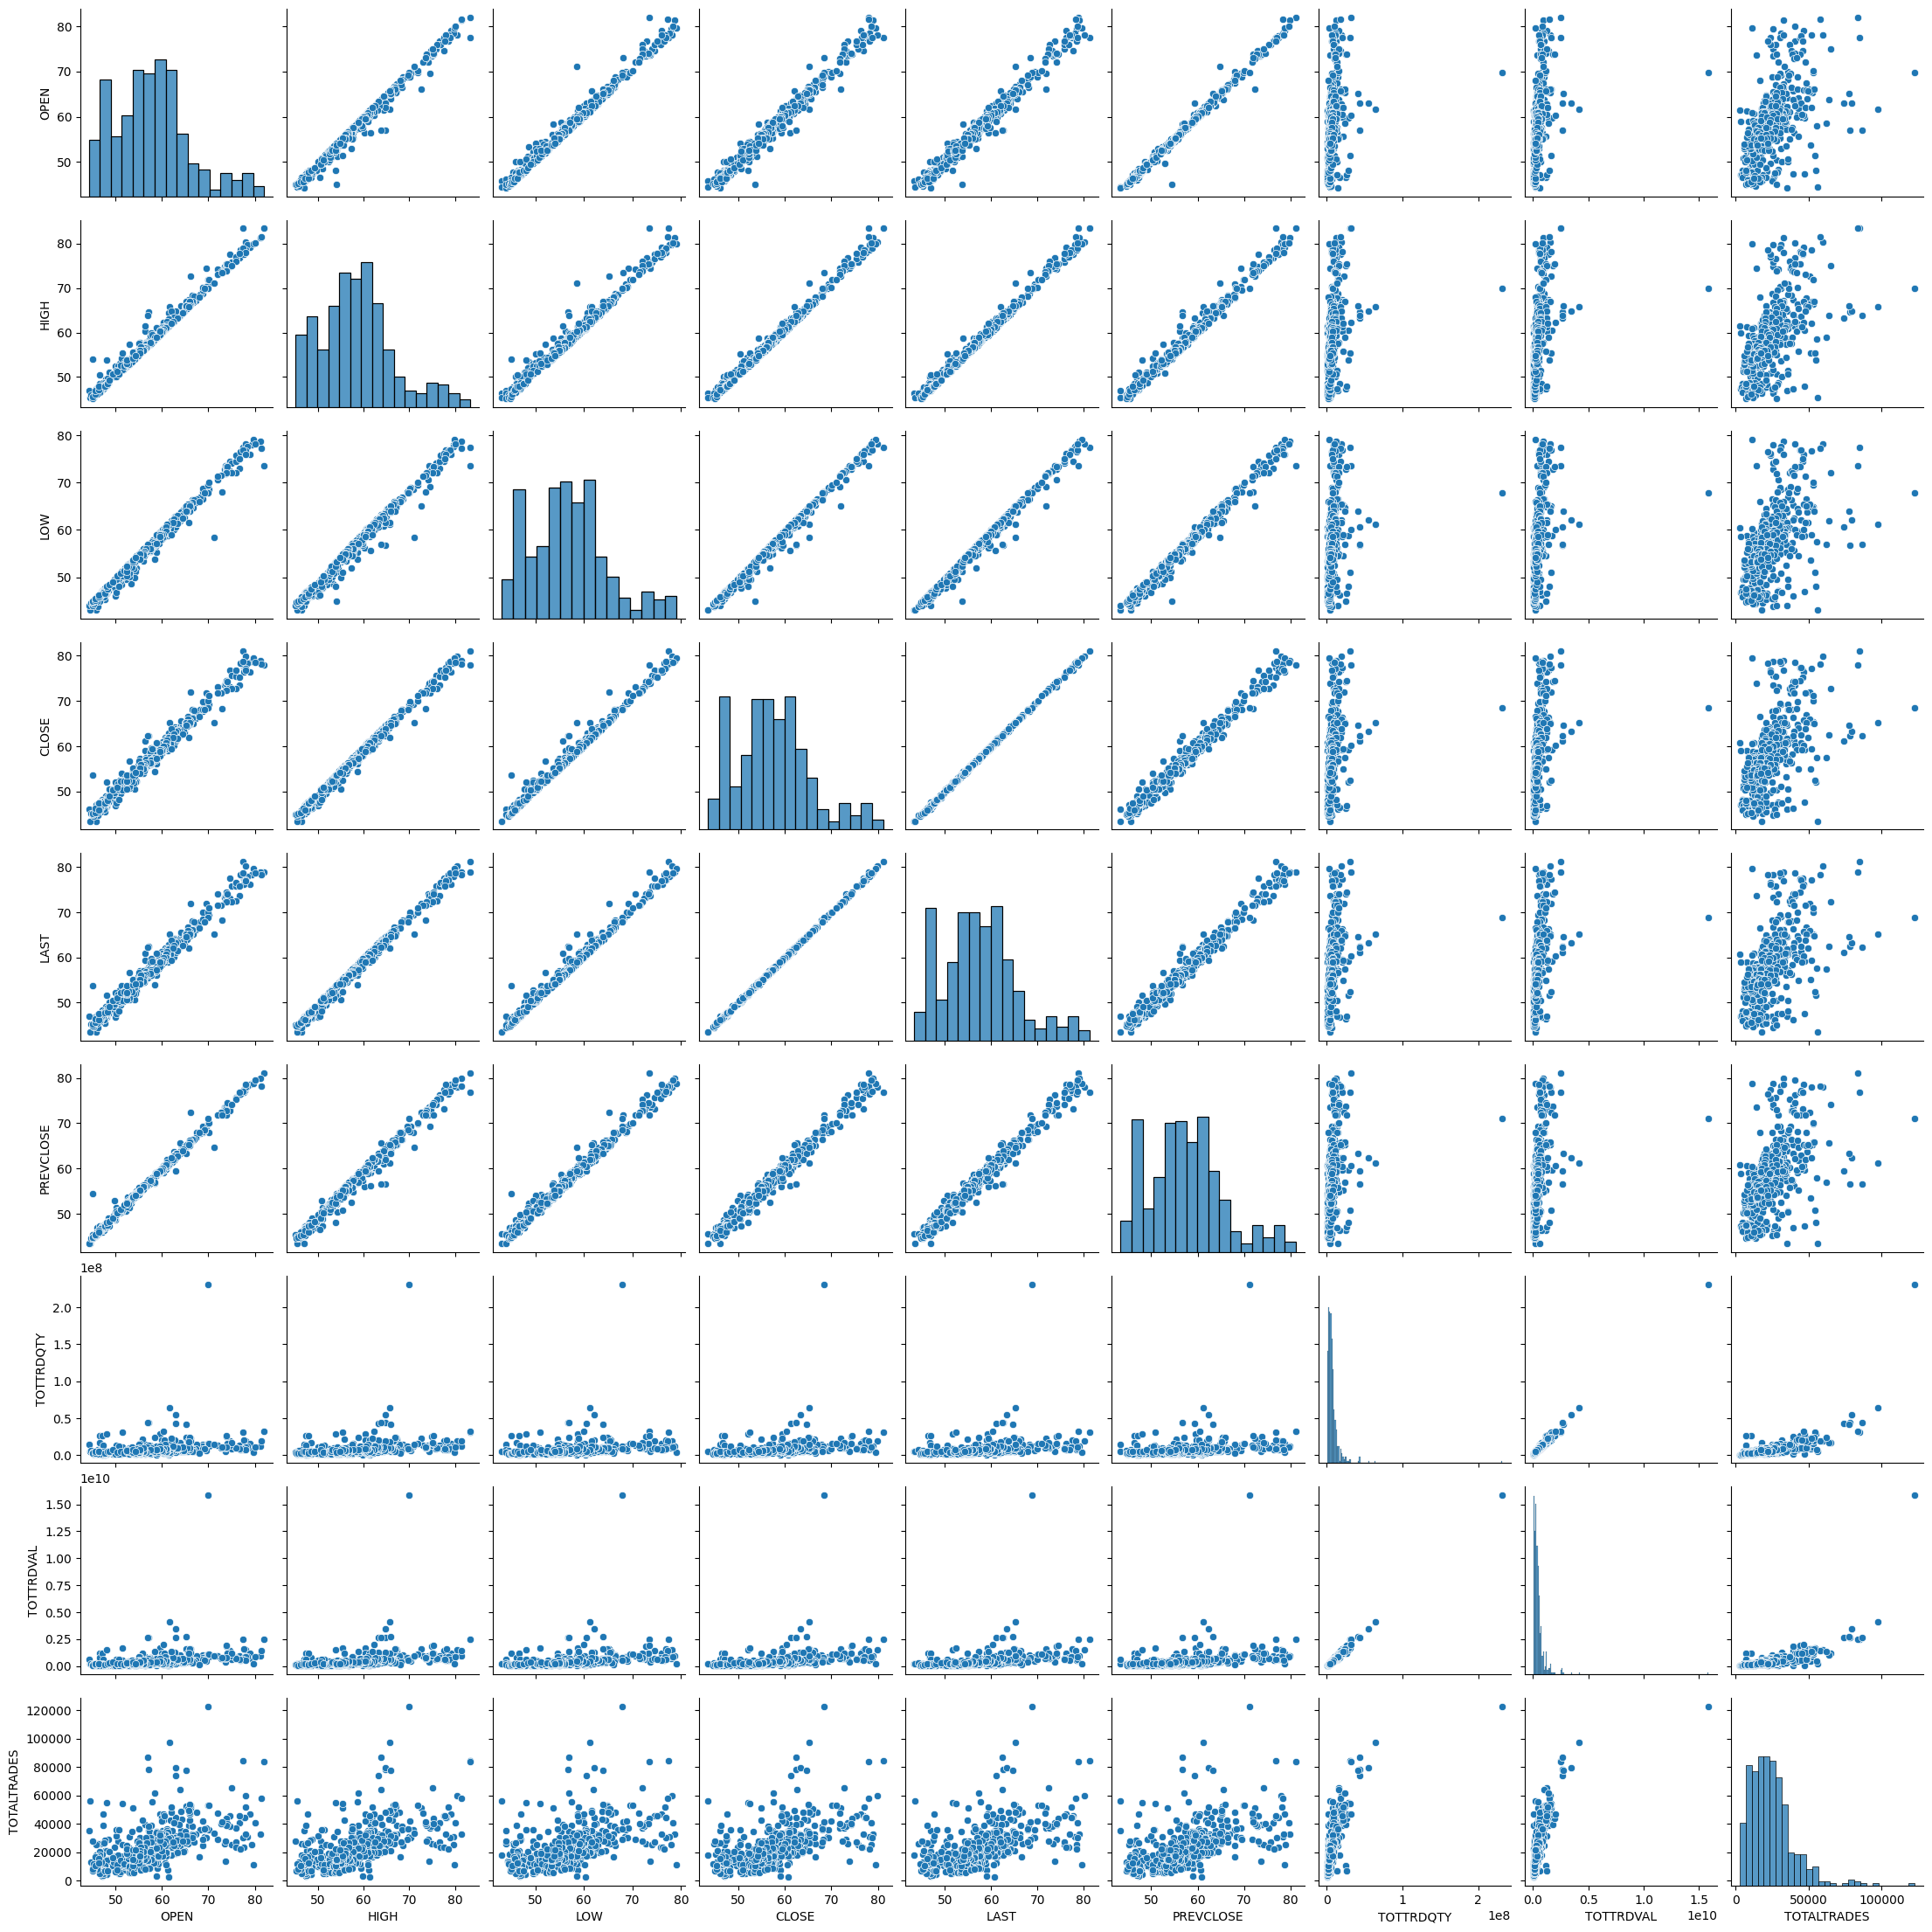

In [160]:
sns.pairplot(idfc)

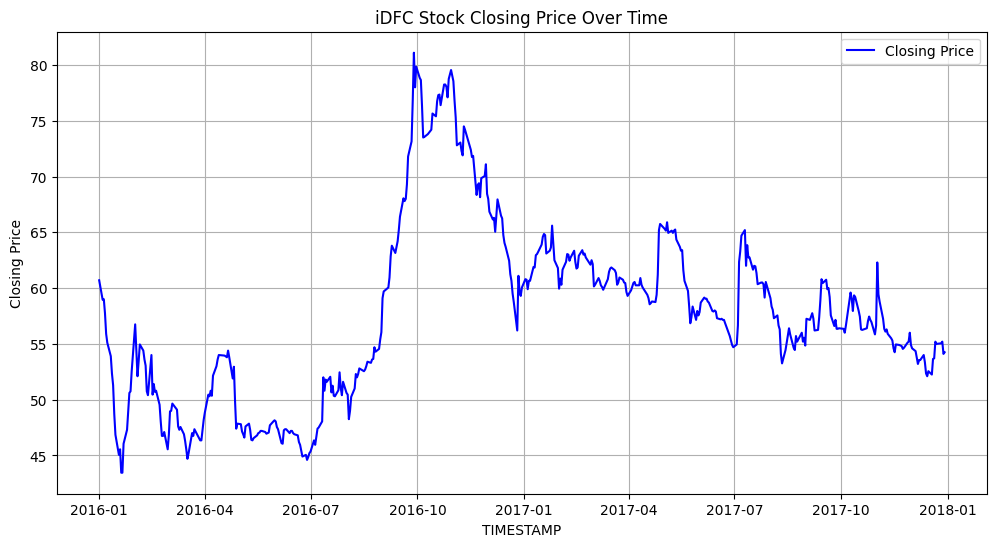

In [161]:
import matplotlib.pyplot as plt

# Plot the stock's closing price over time
plt.figure(figsize=(12, 6))
plt.plot(idfc.index, idfc['CLOSE'], label='Closing Price', color='blue')
plt.title("iDFC Stock Closing Price Over Time")
plt.xlabel("TIMESTAMP")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()


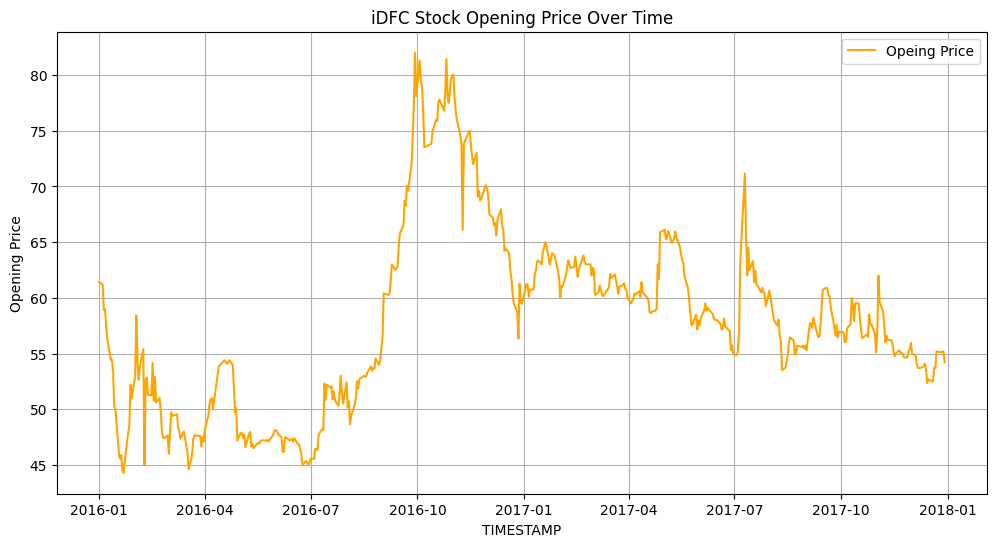

In [162]:
import matplotlib.pyplot as plt

# Plot the stock's closing price over time
plt.figure(figsize=(12, 6))
plt.plot(idfc.index, idfc['OPEN'], label='Opeing Price', color='orange')
plt.title("iDFC Stock Opening Price Over Time")
plt.xlabel("TIMESTAMP")
plt.ylabel("Opening Price")
plt.legend()
plt.grid(True)
plt.show()

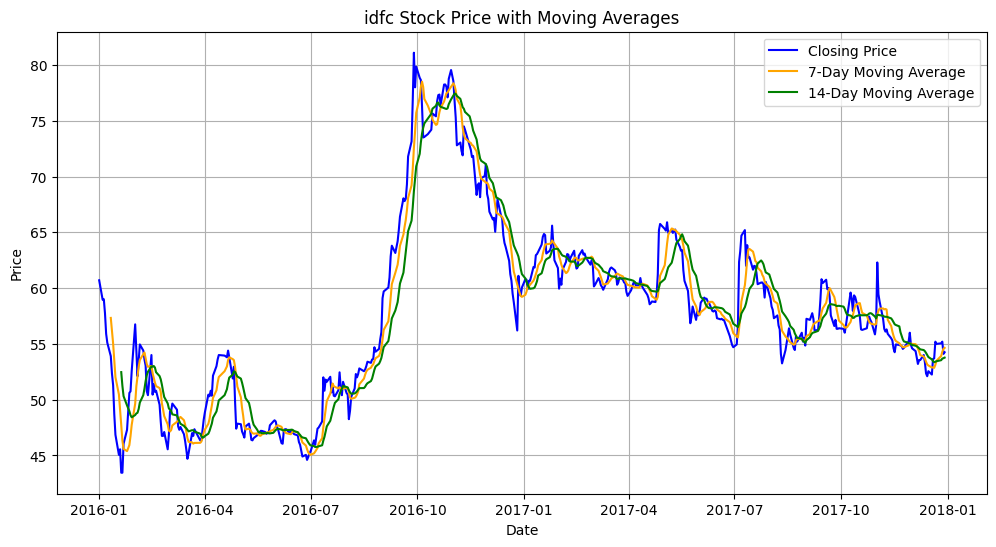

In [163]:
# Add a 7-day and 14-day moving average
idfc['MA_7'] = idfc['CLOSE'].rolling(window=7).mean()
idfc['MA_14'] = idfc['CLOSE'].rolling(window=14).mean()

# Plot closing price with moving averages
plt.figure(figsize=(12, 6))
plt.plot(idfc.index, idfc['CLOSE'], label='Closing Price', color='blue')
plt.plot(idfc.index, idfc['MA_7'], label='7-Day Moving Average', color='orange')
plt.plot(idfc.index, idfc['MA_14'], label='14-Day Moving Average', color='green')
plt.title("idfc Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [164]:
# Correlation matrix
correlation_matrix = idfc.corr()

# Display correlation of each feature with CLOSE
print(correlation_matrix['CLOSE'].sort_values(ascending=False))


CLOSE          1.000000
LAST           0.999786
HIGH           0.995503
LOW            0.993408
PREVCLOSE      0.988958
OPEN           0.987385
MA_7           0.973866
MA_14          0.942425
TOTALTRADES    0.576880
TOTTRDVAL      0.352038
TOTTRDQTY      0.300292
Name: CLOSE, dtype: float64


In [165]:
# Drop weakly correlated features
features_to_drop = ['TOTTRDVAL', 'TOTTRDQTY', 'TOTALTRADES', 'LAST']
idfc = idfc.drop(columns=features_to_drop)

# Check the remaining features
print("Remaining Features:")
print(idfc.columns)

Remaining Features:
Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'PREVCLOSE', 'MA_7', 'MA_14'], dtype='object')


In [166]:
idfc.isnull().sum()

,0
OPEN,0
HIGH,0
LOW,0
CLOSE,0
PREVCLOSE,0
MA_7,6
MA_14,13


In [167]:

idfc=idfc[['CLOSE','OPEN','HIGH','LOW','PREVCLOSE','MA_7'
            ]]

In [168]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

idfc = idfc.fillna(method='ffill')
train_size = int(len(idfc) * 0.8)
train_data = idfc['CLOSE'][:train_size].values
test_data = idfc['CLOSE'][train_size:].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data.reshape(-1, 1))
scaled_test = scaler.transform(test_data.reshape(-1, 1))

# Create sequences for train data
look_back = 60
X_train, y_train = [], []
for i in range(look_back, len(scaled_train)):
    X_train.append(scaled_train[i - look_back:i, 0])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences for test data
X_test, y_test = [], []
for i in range(look_back, len(scaled_test)):
    X_test.append(scaled_test[i - look_back:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshaping X for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

<ipython-input-168-8c65c0af23b1>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  idfc = idfc.fillna(method='ffill')


In [169]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False,
               input_shape=(X_train.shape[1], 1),
               kernel_initializer=HeNormal()))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=8,
                    validation_data=(X_test, y_test),
                    verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.1092 - val_loss: 0.0037
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0330 - val_loss: 9.5235e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0262 - val_loss: 0.0017
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0218 - val_loss: 3.6152e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0191 - val_loss: 0.0011
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0146 - val_loss: 0.0048
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0171 - val_loss: 5.6424e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0114 - val_loss: 0.0015
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0102 - val_loss: 0.0030
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0084 - val_loss: 9.0760e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0068 - val_loss: 7.4030e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - 

In [176]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


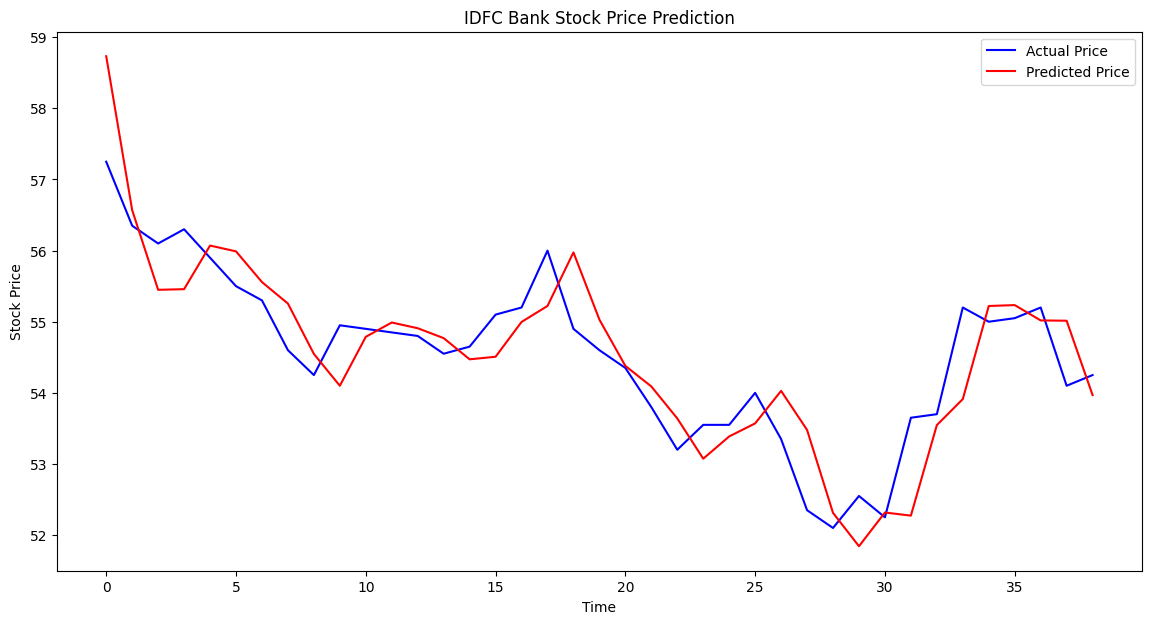

RMSE: 0.6206587070772506
MAE: 0.48646748860677125


In [170]:
import math
# Predict on the test data
predicted_price = model.predict(X_test)

# Inverse the scaling to get the actual price
predicted_price = scaler.inverse_transform(predicted_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14,7))
plt.plot(y_test_actual, color='blue', label='Actual Price')
plt.plot(predicted_price, color='red', label='Predicted Price')
plt.title('IDFC Bank Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate RMSE and MAE for evaluation
rmse = math.sqrt(mean_squared_error(y_test_actual, predicted_price))
mae = mean_absolute_error(y_test_actual, predicted_price)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

In [171]:
# Predict on the training data
train_predicted_price = model.predict(X_train)
train_predicted_price = scaler.inverse_transform(train_predicted_price)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))


# Calculate R² score for train data
train_r2 = r2_score(y_train_actual, train_predicted_price)

# Calculate R² score for test data
test_r2 = r2_score(y_test_actual, predicted_price)

# Print R² scores
print(f"R² score for Training Data: {train_r2}")
print(f"R² score for Test Data: {test_r2}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R² score for Training Data: 0.9804184497408276
R² score for Test Data: 0.712160796707404


In [172]:

# Get the last 60 days from the training data (or test data)
last_days = 60
data_input = idfc[-last_days:].copy()  # Use the last 60 rows as input

# Scale the input data for prediction
scaled_input = scaler.transform(data_input[['CLOSE']])

# Reshape for LSTM model
X_input = scaled_input.reshape((1, last_days, 1))

# Predict next 30 days
predicted_prices = []
for _ in range(30):
    # Make prediction
    predicted_price = model.predict(X_input)

    # Append the predicted price
    predicted_prices.append(predicted_price[0, 0])

    # Update the input for the next prediction by appending the predicted price
    scaled_input = np.append(scaled_input[1:], predicted_price).reshape((last_days, 1))
    X_input = scaled_input.reshape((1, last_days, 1))

# Inverse transform to get actual predicted prices
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Create a DataFrame for future predictions
predicted_dates = pd.date_range(start=idfc.index[-1], periods=31, freq='B')[1:]  # Next 30 business days
predicted_df = pd.DataFrame(predicted_prices, columns=['Predicted Price'], index=predicted_dates)

# Display the predicted values for the next 30 days
print(predicted_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

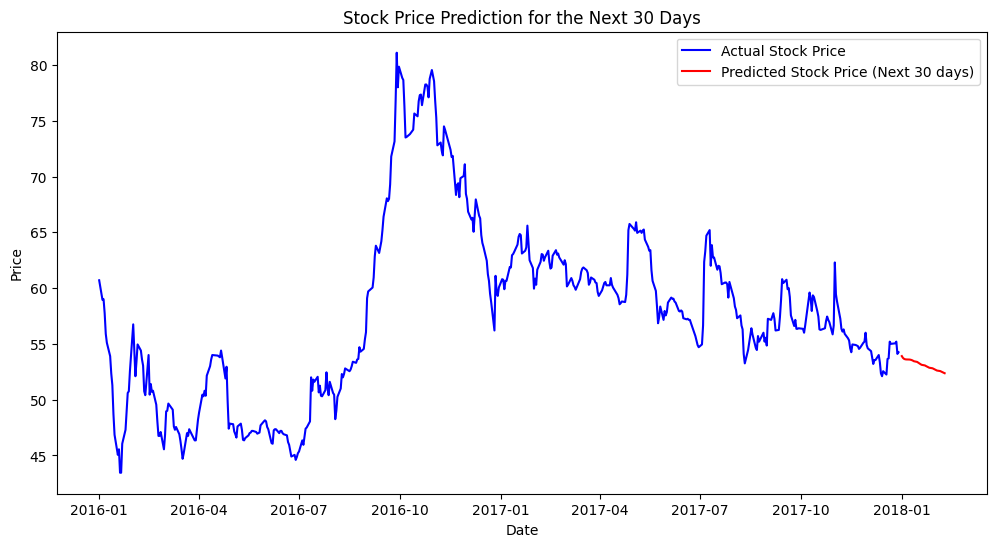

In [173]:

# Plot the actual and predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(idfc.index, idfc['CLOSE'], color='blue', label='Actual Stock Price')
plt.plot(predicted_df.index, predicted_df['Predicted Price'], color='red', label='Predicted Stock Price (Next 30 days)')
plt.title('Stock Price Prediction for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

